Raw reads in FastQC format are preprocessed by the FastQ parsing script

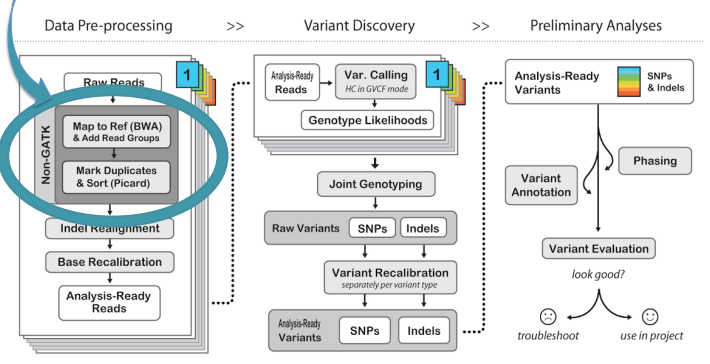

In [27]:
from IPython.display import Image
Image("/data/gbauc/script/pfb2017_gatkteam/e_notebook/fig1.png")

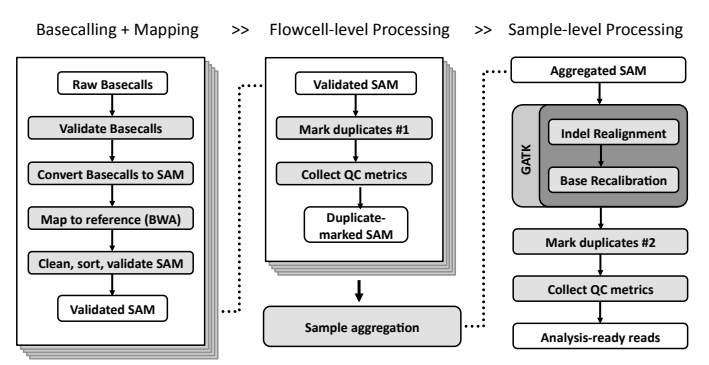

In [26]:
from IPython.display import Image
Image("/data/gbauc/script/pfb2017_gatkteam/e_notebook/fig2.png")

In [ ]:
#!/usr/bin/env python3
# python3 run_bwa_mem.py ./../ref/hg38.fa ./../../cunde/FASTQ/ERR1977350_1.fastq ./../../cunde/FASTQ/ERR1977350_2.fastq > test

import os, sys, re, argparse
import subprocess

Create specific function for each pipeline steps:
STEP 1: Burrow Wheeler Alignement (BWA mem) of sequencing reads using FastQ input and .Bam outputs

In [ ]:
# def run_bwa():
def call_bwa(refgen, fastq_r1, fastq_r2, threads = 1, mark_split = "-M", bwa_output = "bwa_output", my_path = './'):
    #execution = 0
    try:            
        # create bwa output folder
        if not os.path.exists(bwa_output):
            os.makedirs(bwa_output)
        out_file_name = fastq_r1.split("_")[0]
        file_out = "{}/{}/{}.sam".format(my_path,bwa_output,out_file_name)
        #print(file_out)
        log_out =  "{}/{}.log".format(my_path,bwa_output)

        #run bwa mem
        cmd = "bwa mem {} -t {} {} {} {} > {}".format(mark_split, threads, refgen,fastq_r1,fastq_r2,file_out)
        #print(cmd)
        proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        #get output and errors
        outs,errs = proc.communicate()
        #out_file = open(os.path.join(my_path,bwa_output), "w")
        out_log =  open(log_out, "w")

        # write output (from byte to ascii) in .sam
        outs_errs = errs.decode("ascii")
        out_log.write(outs_errs)
        out_log.close()
        execution = file_out

        # check exception content
    except Exception as e:
        #print(str(e))
        execution = None
    return execution  # return the proc object inclunding binary output and error log

STEP 2: Samtools .sam files to .bam conversion and sorting done separately:

In [ ]:
#def run_samtools():
def call_samtools_sort(input_sam, threads = 1, output_format = "BAM", samtools_output = "samtools_output", my_path = './'):
    #execution = 0
    try:
        # create samtools output folder
        if not os.path.exists(samtools_output):
            os.makedirs(samtools_output)       
        file_out = "{}/{}/{}.sorted.bam".format(my_path,samtools_output,sample_name)
        #print(file_out)
        log_out =  "{}/{}.log".format(my_path,samtools_output)

        # run samtools_sort
        cmd = "samtools sort -@ {} {} -O {} -o {}".format(threads, input_sam, output_format, file_out)
        proc = subprocess.Popen(cmd, shell = True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        #print(cmd)
        outs,errs = proc.communicate()
        out_errs = errs.decode("ascii")
        out_log =  open(log_out, "w")
        #print(type(outs))
        out_log.write(out_errs)
        out_log.close()
        execution = file_out
            
    except Exception as e2:
        #print(str(e2))
        execution = None
    return execution 

STEP 3: Picard tools to create a sequence dictionnary

In [ ]:
# def run_picard_CSD
def run_picard_CSD(input_ref, ref_genome = "ref_genome", my_path = "./"):
    execution = 0
    try:
        # create reference genome folder
        if not os.path.exists(ref_genome):
            os.makedirs(ref_genome)
                                
        #run Picard CSD and samtools faidx on reference fasta file
        out_file_name  = os.path.basename(input_ref).split(".") # list of split input bam file name
        out_file = "{}/{}/{}.dict".format(my_path,ref_genome,out_file_name[0])
        cmd = "java -jar /usr/local/anaconda/share/picard-2.14-0/picard.jar CreateSequenceDictionary R={} O={}".format(input_ref, out_file)
        proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        #get output and errors
        outs,errs = proc.communicate()
        out_log =  open("{}.log".format(out_file_name[0]), "w")

        #write output
        out_errs = errs.decode("ascii")
        out_log.write(out_errs)
        out_log.close()

           except Exception as e:
        print(str(e))
        execution = 1
    return execution  #return the proc object inclunding binary output and error log

STEP 4: Samtools to create an Index of .bam files 

In [ ]:
def run_samtools_faidx(input_ref,ref_genome = "ref_genome", my_path = "./"):
    execution = 0
    try:
        # create reference genome folder
        if not os.path.exists(ref_genome):
            os.makedirs(ref_genome)
                                
        #run samtools faidx on reference fasta file
        out_file_name  = os.path.basename(input_ref).split(".") # list of split input bam file name
        out_file = "{}/{}/{}.dict".format(my_path,ref_genome,out_file_name[0])
        cmd = "nohup samtools faidx {}".format(input_ref)
        proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        #get output and errors
        outs,errs = proc.communicate()
        out_log =  open("{}.log".format(out_file_name[0]), "w")

        #write output
        out_errs = errs.decode("ascii")
        out_log.write(out_errs)
        out_log.close()
    except Exception as e:
        print(str(e))

STEP 5: Picard to mark PCR duplicates

In [ ]:
# def call_picard_md()
def call_picard_md(input_bam, picard_MD_output = "picard_MD_output", my_path = "./"):
    execution = 0
    try:

        # create picard output folder
        if not os.path.exists(picard_MD_output):
            os.makedirs(picard_MD_output)
           
        file_out = "{}/{}/{}.mrkdup.sorted.bam".format(my_path,picard_MD_output,sample_name)
        #print(file_out)
        log_out =  "{}/picard.mrkdup.sorted.bam.log".format(my_path)
        #print(log_out)

        # run samtools_sort
        picard_path = 'java -Djava.io.tmpdir=./ -jar /usr/local/anaconda/share/picard-2.14-0/picard.jar'
        cmd = "{} MarkDuplicates I={} O={} M={}.metrics.txt".format(picard_path, input_bam, file_out, file_out)
        proc = subprocess.Popen(cmd, shell = True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        #print(cmd)
        
        # get errors
        outs, errs = proc.communicate()
        out_errs = errs.decode("ascii")
        out_log = open(log_out, "w")
        out_log.write(out_errs)
        out_log.close()
        execution = file_out
    except Exception as e3:
        print(str(e3))
        execution = None
    return execution

STEP 6: Picard to perform AddOrReplaceReadGroups

In [ ]:
#def call_picard_groups():
def call_picard_groups(input_picard_md, picard_arrg_output = "picard_arrg_output", my_path = "./"):
    execution = 0
    try:
        if not os.path.exists(picard_arrg_output):
            os.makedirs(picard_arrg_output)
        file_out = "{}/{}/{}.arrg.mrkdup.sorted.bam".format(my_path,picard_arrg_output,sample_name)
        #print(file_out)
        log_out =  "{}/picard.arrg.mrkdup.sorted.bam.log".format(my_path)
        #print(log_out)
            
        #run gatk HaplotypeCaller
        cmd = "java -jar /usr/local/anaconda/share/picard-2.14-0/picard.jar AddOrReplaceReadGroups I={} O={} RGLB=lib1 RGPL=illumina RGPU=dummy RGSM={}".format(input_$
        proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        #get output and errors
        outs,errs = proc.communicate()
        
        #write output (from byte to ascii)
        out_errs = errs.decode("ascii")
        out_log = open(log_out, "w")
        out_log.write(out_errs)
        out_log.close()
        execution = file_out
        
    except Exception as e:
        print(str(e))
        execution = 1
    return execution  #return the proc object inclunding binary output and error log

STEP 7: Samtools to index the Step6 .bam files output 

In [ ]:
# def call_samtools_index():
def call_samtools_index(input_picard_arrg, picard_arrg_output = "picard_arrg_output", my_path = "./"):
    execution = 0
    try:
        if not os.path.exists(input_picard_arrg):
            os.makedirs(input_picard_arrg)

        file_out = "{}".format(input_picard_arrg) 
        #file_out = "{}/{}/{}.arrg.mrkdup.sorted.bam".format(my_path,picard_arrg_output,sample_name)
        #print(file_out)
        log_out =  "{}/picard.arrg.mrkdup.sorted.bam.log".format(my_path)
        #print(log_out)
        cmd = "samtools index {}".format(file_out)
        proc = subprocess.Popen(cmd, shell = True, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        #print(cmd)
        
        # get errors
        outs,errs = proc.communicate()
        out_errs = errs.decode("ascii")
        out_log = open(log_out, "w")
        out_log.write = (out_errs)
        out_log.close()
        execution = file_out
        
    except Exception as e:
        print(str(e))
        execution = 1
    return execution  #return the proc object inclunding binary output and error log


STEP 8: Genome Analysis ToolKit to perform SNP calling on 

In [ ]:
def run_gatk(refpath, bamfile, gatk_out = "gatk_out", my_path = "./", conf = 30):
    execution = 0
    try:
        if not os.path.exists(gatk_out):
            os.makedirs(gatk_out)
        print("test")
        #run gatk HaplotypeCaller
        out_file_name = os.path.basename(bamfile).split(".ba")[0]
        print(out_file_name)
        file_out = "{}/{}/{}.vcf".format(my_path,gatk_out,out_file_name)
        print(file_out)
        cmd = "gatk -T HaplotypeCaller -R {} -I {} --genotyping_mode DISCOVERY -stand_call_conf {} -o {}".format(refpath, bamfile, conf, file_out)
        print(cmd)
        proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        #get output and errors
        outs,errs = proc.communicate()
        out_log =  open("{}.log".format(file_out), "w")

        #write output (from byte to ascii) in .sam
        out_errs = errs.decode("ascii")
        out_log.write(out_errs)
        out_log.close()
        execution = file_out

    except Exception as e:
        print(str(e))
        execution = 1
    return execution  #return the proc object inclunding binary output and error log



MAIN FUNCTION  to call sequencially steps 1-8:

In [ ]:
def main():

    # 
    parser = argparse.ArgumentParser(description='run snp calling pipeline')
    parser.add_argument('--ref', action="store", dest= "refgen", help= 'path to reference genome.fa')
    parser.add_argument('--R1', action="store", dest= "fastq_R1", help = 'fastq file R1')
    parser.add_argument('--R2', action="store", dest= "fastq_R2", help = 'fastq file R2')
    #parser.add_argument('-t', action="store", dest= "threads", help = 'bwa threads number')
    parser.parse_args()
    
    #### BWA function
    #################
    
    # create bwa output folder
    if not os.path.exists(bwa_output):
            os.makedirs(bwa_output)
    out_file_name = fastq_r1.split("_")[0]
    file_out = "{}/{}/{}.sam".format(my_path,bwa_output,out_file_name)
    #print(file_out)
    log_out =  "{}/{}.log".format(my_path,bwa_output)

    # get function output and  error:
    filepath_bwa = call_bwa(refgen, fastq_r1, fastq_r2, threads=threads)
    if filepath_bwa is None:
        print('"something went wrong in bwa"')
        sys.exit(1)
    #print('out_bwa',filepath_bwa)
    #sys.exit(0)
    
    #### SAM function
    #################
    
    input_sam = filepath_bwa
    #print(input_sam)
    sample_name = os.path.basename(input_sam)
    sample_name = os.path.splitext(sample_name)[0]
    #print(sample_name)
    
    
    # get function output and  error: 
    filepath_samtool = call_samtools_sort(input_sam)
    if filepath_samtool is None:
    print('"something went wrong in samtools"')
        sys.exit(1)
    #print(filepath_samtool)
    #sys.exit(0)
    
    #### PICARD FAIDX
    #################
    
    # creating sequence dictionary with Picard
    
    input_ref = sys.argv[1] #full path to ref fasta
    #outpath = sys.argv[2]
    
    picard = run_picard_CSD(input_ref)
    samtools = run_samtools_faidx(input_ref)
    #print('outvalue of picard', picard)
    #print('outvalue of samtools', samtools)
    run_picard_CSD(input_ref)
    run_samtools_faidx(input_ref)
    #sys.exit(0)
    
    #### PICARD MD function
    ####################
    # Function will return a '.mrkdup.sorted.bam' file
    
    input_bam = filepath_samtool
    #print(input_bam)
    sample_name = (os.path.basename(input_bam)).split('.')[0]
    #print(sample_name)
    #my_path = os.getcwd()
    #print('current_dir', dir_path)
    
    # get function output and  error:
    filepath_picard_md = call_picard_md(input_bam)
    if filepath_picard_md is None:
        print('"something went wrong in Picard_mark_duplicates"')
        sys.exit(1)
    print('picard MD', filepath_picard_md)
    #sys.exit(0)
                
    ##### PICARD function ARRG
    ##########################
    
    input_picard_md = filepath_picard_md
    #print(input_picard_md)
    sample_name = (os.path.basename(input_picard_md)).split('.')[0]
    #sample_name = os.path.basename(input_bam).split(".")
    #print(sample_name)
    
    outpath = sys.argv[2]
    
    filepath_picard_arrg = call_picard_groups(input_picard_md)
    print(filepath_picard_arrg)
    
    if filepath_picard_arrg is None:
        print('"something went wrong in Picard_ARRG"')
        sys.exit(1)
    print('picard arrg',filepath_picard_arrg)
    #sys.exit(0)

    #### Samtool indexing
    #####################
    # take a aarg.mrkdup.sorted.bam file and index it.
    # Function will return a 'aarg.mrkdup.sorted.bam.bai' file
    # We will use the function as one step in our 'pipeline'.
    
    input_picard_arrg = filepath_picard_arrg
    print('input_picard_arrg', input_picard_arrg)
    #sample_name = (os.path.basename(input_bam)).split('.')[0]
    sample_name = (os.path.basename(input_picard_arrg)).split('.')[0]
    #print(sample_name)
    
    filepath_picard_arrg = call_samtools_index(input_picard_arrg)
    print(filepath_picard_arrg)
        
    if filepath_picard_arrg is None:
        print('"something went wrong in Picard indexing"')
        sys.exit(1)
    print('samtool indexing',filepath_picard_arrg)
    #sys.exit(0)
                                        
    #### run GATK
    #############
    
    
    #get input  params
    refpath = sys.argv[1]
    print(refpath)
    bamfile = filepath_picard_arrg
    print(bamfile)
    
    #conf = int(sys.argv[3])
    #outpath = sys.argv[4]
    
    #sample_name = (os.path.basename(bamfile)).split('.')[0]
    #print(sample_name)
    
    
    filepath_gatk = run_gatk(refpath, bamfile)
    print(filepath_gatk)
    
    if filepath_gatk is None:
        print('"something went wrong in GATK"')
        sys.exit(1)
    print(filepath_gatk)
    #sys.exit(0)               

if __name__=="__main__":
    main()






## element to be taken care of:
-Current script requires input files to be in the same dir (or sim-linked)
-remove current file creation from specific function
-Redirect log files to specific folders and append sample name
